In [1]:
%reload_ext autoreload
%autoreload 2

import torch
import matplotlib
import os
import matplotlib.pyplot as plt
from estimators.data import TraversabilityDataset, get_transform
from estimators.data.TraversabilityDataset import PatchesDataset
from estimators.utils import get_learner
from utilities.postprocessing.utils import KrockPatchExtractStrategy
from utilities.patches import *
from interpretability import *
from utilities.patches import *
from jupyterthemes import jtplot
from estimators.utils import load_model_from_name
from matplotlib.patches import Rectangle

from torch.nn.functional import softmax, relu
from torch.nn.functional import adaptive_avg_pool2d
from torch.utils.data import DataLoader
import functools
import operator
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns


/home/francesco/.local/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
from jupyterthemes import jtplot
jtplot.reset()
#
# plt.style.use(['science', 'ieee'])

plt.style.use(['science'])

matplotlib.rcParams['figure.figsize'] = (15, 15)
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

# Parameters

In [3]:
model_name = 'microresnet#3-gate=7x7-n=1-se=True'
model_dir = '/media/francesco/Carino/vaevictis/data/1558825182.753924'
# model_dir = '/media/francesco/Carino/vaevictis/data/1559690958.4176426'

BASE_DIR = '/media/francesco/saetta/krock-dataset/test/'
TEST_META = BASE_DIR + '/meta.csv'

TEST_ROOT = '/media/francesco/saetta/krock-dataset/new-test-random/csvs_patches'
PATCHES_DIR = '/media/francesco/saetta/krock-dataset/new-test-random/patches/0.71/'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
module = load_model_from_name(model_dir + '/roc_auc.pth', model_name ).to(device)
# module = module.eval().to(device)

MAX_ADVANCEMENT = 0.70
seconds = 4
time_window = 100
device

device(type='cuda')

In [4]:
ds = TraversabilityDataset.from_root('/media/francesco/saetta/krock-dataset/new-test-random/100/', 
                                      patches_dir='/media/francesco/saetta/krock-dataset/new-test-random/100/patches/', 
                                     time_window = 50*2, patch_size=0.7, tr=0.2, transform=get_transform(debug=False), return_info=True)

# ds = TraversabilityDataset.from_root('/media/francesco/saetta/krock-dataset/train/100/', 
#                                      patches_dir='/media/francesco/saetta/krock-dataset/train/100/patches/', 
#                                      time_window = 50*2, patch_size=0.7, tr=0.2, transform=get_transform(debug=False), return_info=True)

import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)


In [5]:
out_dir = '/home/francesco/Documents/Master-Thesis/papers/Thesis/img/5/pca/'

class Storage():
    """
    This class keep an internat buffer to store the outputs of a specific layer
    """
    def __init__(self):
        self.data = None
        
    def __call__(self, module, input, outputs):
        if self.data is None: self.data = outputs
        else:
            self.data = torch.cat([self.data, outputs])
    def reset(self):
        self.data = None
        
def run_and_stop(at=10):
    targets = None
    images_paths, heights = [], []
    stop_at = 10
    for i, batch in enumerate(dl):
        x = batch[0].cuda()
        images_paths.append(batch[2])
        heights.append(batch[3].tolist())
        if targets is None: targets =  batch[1]
        else:
            targets = torch.cat([targets, batch[1]])
        out = module(x)
        pred = torch.argmax(softmax(out), -1)
        if i == stop_at: break
                    

    handler.remove()
    
    return targets, images_paths, heights

def PCA(x, k=2):
    # preprocess the data
    X_mean = torch.mean(x,0)
    x = x - X_mean.expand_as(x)
    # svd
    U,S,V = torch.svd(torch.t(x))
    return torch.mm(x,U[:,:k])

In [6]:
k = 2
storage = Storage()
# hook the storage to the last conv layer just before the fc
handler =  module.encoder.layers[-1].layer[0].register_forward_hook(storage) 
dl = DataLoader(ds, batch_size=1024, num_workers=14, pin_memory=True, shuffle=True)
module = module.to(device)
# run the model on the dataset and get the targets
targets, images_paths, heights = run_and_stop(10)
targets = targets.cpu().numpy().astype(int)
images_paths = functools.reduce(operator.concat, images_paths)
heights = functools.reduce(operator.concat, heights)
# average the features vector to get a [BATCH_SIZE X N_POINT X 1]
x =  storage.data.view((storage.data.shape[0], -1))
# run PCA on the points 
pca = PCA(x, k).cpu().detach().numpy()

x.shape

/home/francesco/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([11264, 1152])

In [7]:
%matplotlib notebook

<IPython.core.display.Javascript object>


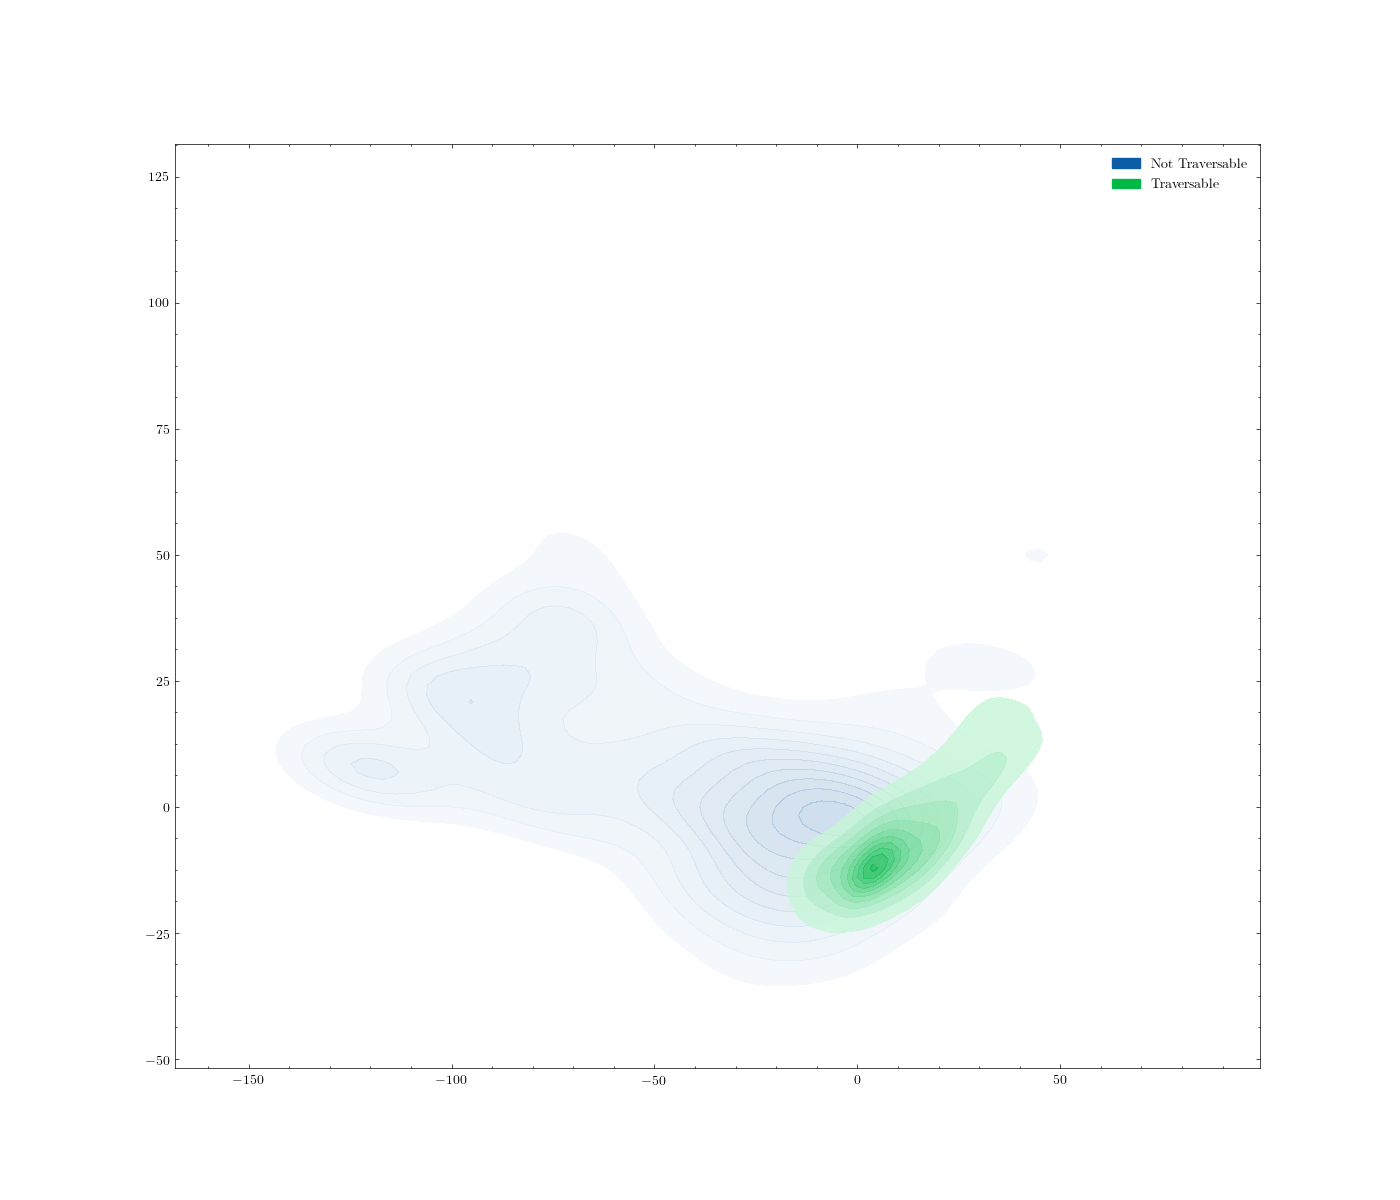

/home/francesco/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


<IPython.core.display.Javascript object>


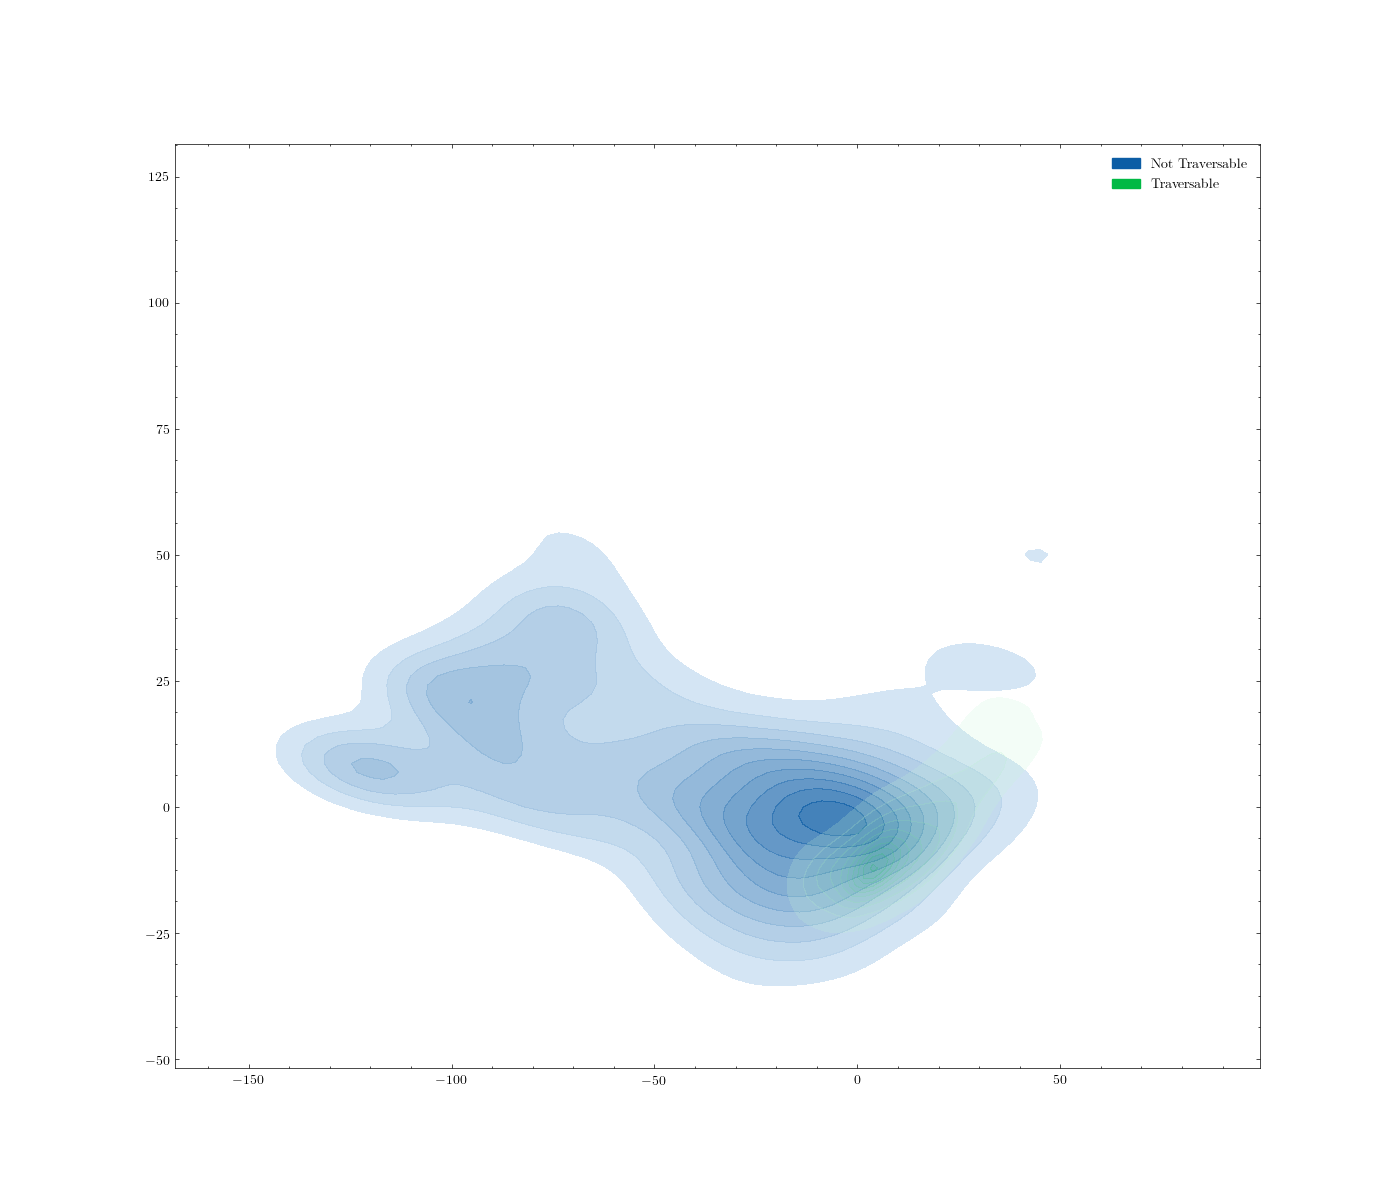

In [8]:
from mpl_toolkits.mplot3d import Axes3D
out_dir = '/home/francesco/Documents/Master-Thesis/papers/Thesis/img/5/pca/'

def make_2d_scatter(pca, save_path, density=False, class_hightlight=None):
    fig = plt.figure()
    has_z = pca.shape[-1] == 3
    if has_z: ax = fig.add_subplot(111, projection='3d')
    for i, target_name in enumerate(['Not Traversable', 'Traversable']):
        idx = targets == i
        alpha = 0.7
        if class_hightlight is not None: alpha = 0.8 if i == class_hightlight else 0.2
        if has_z: ax.scatter(pca[idx, 0], pca[idx, 1], pca[idx, 2], s=3, label=target_name, alpha=alpha)
        else:
            if density: sns.kdeplot(pca[idx, 0], pca[idx, 1], shade=True, shade_lowest=False,  alpha=alpha, label=target_name)
            else:plt.scatter(pca[idx, 0], pca[idx, 1], s=3, label=target_name, alpha=alpha)
    plt.legend()
    plt.savefig(save_path, dpi= 400, bbox_inches='tight', transparent=True)
    plt.show()
matplotlib.rcParams['figure.figsize'] = (14, 12)

# make_2d_scatter(pca, out_dir + '/pca-density.png')
make_2d_scatter(pca, out_dir + '/pca-test-1-density.png', class_hightlight=1, density=True)
make_2d_scatter(pca, out_dir + '/pca-test-0-density.png', class_hightlight=0, density=True)

In [10]:
df = pd.DataFrame(data = {'x' : pca[:,0], 'y' : pca[:, 1], 'height': heights, 'images': images_paths, 'targets' : targets})

df.to_csv(out_dir + '/pca-test.csv')


### Store the patches

In [3]:
out_dir = '/media/francesco/saetta/quarry-grad/test/collage/'
patches_dir = '/media/francesco/saetta/krock-dataset/new-test-random/100/patches/'

df = pd.read_csv('/home/francesco/Documents/Master-Thesis/papers/Thesis/img/5/pca/pca-test.csv')
total = 2000
skip_every = len(df) // total

# to make the background transparent use
# $ for file in *.png; do convert $file -transparent white transparent-$file; done

In [4]:
for idx, row in df[::skip_every].iterrows():
    p = Patch.from_path(patches_dir + row['images']) 
    p.hm *= row['height']
    save_path = out_dir + '/{}.png'.format(os.path.splitext(row['images'])[0])
    p.plot3d_mayavi(0.02, size=(513,513), distance=2.5 + max(1, row['height'] // 5), azimuth=0, elevation=45, mesh=True, save_path=save_path)
#     save_path = out_dir + '/viridis-{}.png'.format(os.path.splitext(row['images'])[0])
#     p.plot3d_mayavi(0.02, size=(513,513), distance=2.5 + max(1, row['height'] // 2), azimuth=0, elevation=45, mesh=True, colormap='viridis', save_path=save_path)
    del p

## Plotting patches

In [11]:
import gc

gc.collect()

23

In [4]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.cluster import KMeans

df = pd.read_csv('/home/francesco/Documents/Master-Thesis/papers/Thesis/img/5/pca/pca.csv')
patches_dir = '/media/francesco/saetta/quarry-grad/collage_transparent/'
out_dir = '/home/francesco/Documents/Master-Thesis/papers/Thesis/img/5/pca/'

df =  df[::skip_every]
coords = np.stack([df['x'].values, df['y'].values], -1)
estimator = KMeans(n_clusters=200)
estimator.fit(coords)

clusters_dfs= [df.iloc[np.where(estimator.labels_ == i)] for i in range(estimator.n_clusters)]
       
# def imread(path):
#     im = cv2.imread(path)
#     return cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)

# fig, ax = plt.subplots()
# ax.scatter(df['x'].values, df['y'].values, alpha=0)    

# for idx, row in df[::500].iterrows():
#     x,y, img_name = row[['x', 'y', 'images']]
#     path = patches_dir + 'transparent-' + img_name
#     ab = AnnotationBbox(OffsetImage(plt.imread(path), zoom=0.05), (x, y), frameon=False)
# #     ab = AnnotationBbox(OffsetImage(plt.imread(path), zoom=0.05), (x, y), frameon=False)
#     ax.add_artist(ab)
    
# plt.show()

# fig.savefig(out_dir + '/pca-patches.png')

In [5]:
       
def imread(path):
    im = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)

fig, ax = plt.subplots()
ax.scatter(df['x'].values, df['y'].values, alpha=0)    

for df in clusters_dfs:
    row = df.iloc[len(df) // 2]

    x,y, img_name = row[['x', 'y', 'images']]
    path = patches_dir + 'transparent-' + img_name
    ab = AnnotationBbox(OffsetImage(plt.imread(path), zoom=0.05), (x, y), frameon=False)
#     ab = AnnotationBbox(OffsetImage(plt.imread(path), zoom=0.05), (x, y), frameon=False)
    ax.add_artist(ab)
    del ax

# plt.show()

fig.savefig(out_dir + '/pca-patches.png', dpi=400)

/home/francesco/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


# Analize Quarry Test Set
We are going to use the test set created from simulations run on the Quarry map to understand the model behaviour. We will try to answer different questions, such as "Which are the easiest traversable patches?" or "Are they any ground feature that can misslead the model?".

In [12]:
ds = TraversabilityDataset.from_root('/media/francesco/saetta/krock-dataset/new-test-random/100/', 
                                     patches_dir='/media/francesco/saetta/krock-dataset/new-test-random/100/patches/', 
                                     time_window = 50*2, patch_size=0.7, tr=0.2, transform=get_transform(debug=False))
learner, _ = get_learner(model_name, model_dir, [], dataset=ds)
explain = ExplainModel.from_leaner(learner, ds)

36128


/home/francesco/Documents/Master-Thesis/core/interpretability/__init__.py:35: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df = pd.concat([df, ds.df])


In [ ]:
explain.by_looking_at().tell(ClassificationAnswer.from_explain).plot_confusion_matrix()

## Visualize the best and worst patches sorted by advancement

In [13]:
# explanations = explain.by_looking_at([ Best(), Worst()],how_many=100, every=250)

explanations = explain.by_looking_at([
                                      Shuffle(FalsePositive()),
                                      Shuffle(FalseNegative()),
                                      Shuffle(Worst()),
                                      Shuffle(Best()),
                                     ], how_many=100)
base_dir = '/media/francesco/saetta/quarry-grad/'
for name, explanation in explanations.items():
        explanation.df = explanation.df.sort_values('advancement')
        print(explanation.df['advancement'])
        answers = explanation.tell(PatchAnswer.from_explain) 
        save_dir = '{}/{}'.format(base_dir, name)
        os.makedirs(save_dir, exist_ok=True)
        for i, answer in enumerate(answers):
            grad_cam_p = answer.grad_cam(module, device)
#             answer.plot2d().savefig('{}/patch-2d-{}'.format(save_dir,i), bbox_inches='tight', transparent=True)
#             answer.heatmap((8,8)).plot2d().savefig('{}/heatmap-2d-{}'.format(save_dir,i), bbox_inches='tight', transparent=True)

#             fig = plt.figure()
#             fig = grad_cam_p.plot2d()
#             ax = fig.gca()
#             circle=plt.Circle((36, grad_cam_p.hm.shape[0]//2),4,color='r', fill=False)
#             ax.add_artist(circle)
#             plt.show()
            save_path = save_path='{}/{:02d}-patch-3d-majavi-colormap-{}.png'.format(save_dir, int(explanation.df['advancement'].iloc[i] * 100), i)
            answer.plot3d_mayavi(0.02, size=(513,513), distance=3.5, azimuth=0, elevation=20, mesh=True, save_path=save_path, scalars=grad_cam_p.hm, colormap='viridis')
            

35834    0.201436
15195    0.206336
24744    0.208517
35839    0.209481
15161    0.209597
15194    0.213821
29344    0.220460
15094    0.222190
13036    0.223903
36070    0.227005
24831    0.229527
29294    0.231498
13035    0.232478
24751    0.233182
15191    0.237794
24814    0.240538
4055     0.242590
4064     0.243595
15163    0.245010
24806    0.245740
29674    0.247316
15209    0.249698
29293    0.251704
4058     0.254031
15189    0.254187
36105    0.255814
24823    0.256072
13032    0.256857
24818    0.257720
32231    0.259096
           ...   
32281    0.345457
4114     0.351792
32285    0.354307
32286    0.356087
4109     0.362824
28592    0.363721
24791    0.365308
24790    0.367859
28591    0.370539
24786    0.377256
16693    0.392899
16696    0.398989
36121    0.405921
28584    0.416623
8942     0.424088
36123    0.444188
16706    0.467037
6450     0.469265
36127    0.520480
16724    0.583861
4819     0.599076
4820     0.599230
4861     0.605019
4860     0.605648
4857     0

## Most traversable patches
We expect the esiest traversable patches to be mostly flat. The following figure shows five patches sorted by the *traversable* class probability from the test set.

In [ ]:
explanations = explain.by_looking_at([
                                      Shuffle(FalsePositive()),
                                      Shuffle(FalseNegative()),
                                      Shuffle(Worst()),
                                      Shuffle(Best()),
                                     ], how_many=5)

In [ ]:
explanations['best'].tell(PatchAnswer.from_explain)[0].plot3d_mayavi(0.02, size=(513,513), distance=3.5, save_path='/home/francesco/Desktop/diocane.png', azimuth=0, elevation=35, mesh=True, colormap='viridis', vmax=1)

In [ ]:
import os
plt.style.use(['science', 'ieee'])
module = module.eval()
class MyExplanationsSaver():
    def __init__(self, base_dir):
        self.base_dir = base_dir
            
    def __call__(self, explanations):
        for name, explanation in explanations.items():
            answers = explanation.tell(PatchAnswer.from_explain)
            save_dir = '{}/{}'.format(self.base_dir, name)
            os.makedirs(save_dir, exist_ok=True)
            print(answers)
            for i, answer in enumerate(answers):
                answer.plot2d().savefig('{}/patch-2d-{}'|.format(save_dir,i), bbox_inches='tight', transparent=True)
                answer.grad_cam(module.eval(), device, target_class=0).plot2d().savefig('{}/grad-cam-2d-{}'.format(save_dir,i), bbox_inches='tight', transparent=True)
                answer.heatmap((8,8)).plot2d().savefig('{}/heatmap-2d-{}'.format(save_dir,i), bbox_inches='tight', transparent=True)
                answer.plot3d(title='', rstride=1, cstride=1,)[0].savefig('{}/patch-3d-{}'.format(save_dir,i), bbox_inches='tight', transparent=True)
                answer.plot3d_mayavi(0.02, size=(513,513), distance=3.5, save_path='{}/patch-3d-majavi-colormap-{}.png'.format(save_dir,i), azimuth=0, elevation=35, mesh=True, colormap='viridis', vmax=1)
                plt.close("all")
                
MyExplanationsSaver('/home/francesco/Documents/Master-Thesis/papers/Thesis/img/5/quarry/')(explanations)

In [ ]:
def plot_answer(answer):
    answer.plot2d()
    answer.grad_cam(module, device).plot2d()
    answer.heatmap((8,8)).plot2d()
#     _ = answer.plot3d()[0]

Clearly, most of the patches are flat. The first patch is entirery flat, looking at the heights we can see that every value is zero. Interesting, the grad cam thinks highlights the middle of the patch. Grad cam creates a circle in the middle where the maximum activation point is exactly at the Krock's head position, 36 pixels from the left. Interesting, the highligthed region corespond to the Krock position while walking in flat ground. Correctly the full Krock footprint is highligthed while the corners are not taken into account since the robot won't ever reach them. So, our model is looking at the head position, at the robot footprint and at the future possible reachable region.

In [ ]:
answers = explanations['best'].tell(PatchAnswer.from_explain)

plot_answer(answers[0])

In [ ]:
for answers in explanations.values():
    for answer in answers:
        answers[idx].plot2d()
        answers[idx].grad_cam(module, device).plot2d()
        answers[idx].heatmap((8,8)).plot2d()
        _ = answers[idx].plot3d()[0]
# answers[idx].add_advancement_using_simulator(3, 100).plot2d()

In [ ]:
Patch.plot_all_2d(answers)

In [ ]:
import gc

gc.collect()

# Custom Patches


We can test the robustness of the model by creating custom patches with trivial geometric shapes, walls/bumps, and test the model by comparing its prediction to the real robot in the simulator.

In [4]:

def get_distance(offsets):
    from_left = patch_shape[1] - offsets - size 
    return (from_left - (krock_body + 8)) * 2

def get_answers_from_patches(patches):
    walls_ds = PatchesDataset(patches=patches, transform=get_transform())
    learner, _ = get_learner(model_name, model_dir, [], dataset=walls_ds)
    learner.model = learner.model.eval()
    explain = ExplainModel.from_leaner(learner, walls_ds)
    answer = explain.tell(answer=CustomPatchAnswer.from_explain)
    return answer, explain

def store_figures(figures, out_path):
    for i, fig in enumerate(figures):
        fig[0].savefig('{}{}.png'.format(out_path,i), bbox_inches='tight', transparent=True)
        
def save2d_and_2d(p, out_dir, n):
    p.plot2d().savefig(out_dir + '/{}-2d.png'.format(n))
    p.plot3d_mayavi(0.02, size=(513,513), distance=3.5, save_path=out_dir + '/{}-3d.png'.format(n), azimuth=0, elevation=35, mesh=True, colormap='viridis', vmax=1)
    
    
def make_heatmap(data):
    pred_reshape = data.reshape(len(heights), len(offsets_rev))
    matplotlib.rcParams['figure.figsize'] = (16,14)

    fig = plt.figure()
    ax = sns.heatmap(pred_reshape, annot=pred_reshape, 
                     cmap='viridis',
                     fmt='.2f', 
                     )
    ax.set_yticklabels(['{:.1f}'.format(h * 100) for h in heights], rotation=0)
    ax.set_xticklabels([int(d) for d in  distance],  rotation=0)
    ax.set_ylabel('Height (cm)',  fontsize=18)
    ax.set_xlabel('Distance from Krock\'s head (cm)',  fontsize=18)

    return fig, ax

## Walls at different positions in front of Krock
The most trival way to correctly test the model is to place different walls in front of krock at an increasing distance. The wall is 1 meter high, so it is not traversable, but we had a treshold of 20cm, meaning that, even if the wall is not traversable, when it is at more than 20cm from krock on flat ground the model should yield true. We are going to test the model with different patches starting with a wall placed exactly in front of the robot, then we will move the wall one cm at the time till the end of the patch.

In [5]:
out_dir = '/home/francesco/Documents/Master-Thesis/papers/Thesis/img/5/custom_patches/walls_front'
patch_shape = KrockPatchExtractStrategy.patch_shape(MAX_ADVANCEMENT)
size = 8
res = 0.02
krock_body = 36
surely_in_front_of_krock = krock_body + 8 + size  # head is at 14cm (7px) from the krock's pose
from_right = patch_shape[0] - surely_in_front_of_krock

offsets = np.arange(0, from_right)
offsets = np.unique(offsets.astype(np.int))

In [6]:
offsets

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])

In [ ]:
walls = [WallPatch(KrockPatchExtractStrategy.patch_shape(MAX_ADVANCEMENT), strength=1, back=False, offset=int(offset), size=size)() for offset in offsets]

answer, explanation = get_answers_from_patches(walls)

In [ ]:
distance = get_distance(offsets)
explanation.df['distance'] = distance # convert back to cm and to 'in front of krock coordinates'
explanation.df.to_csv(out_dir + 'walls_front.csv')
explanation.df

We can say that the model classifies all the wall between 0cm to 19cm from krock's head as no traversable and the ones more than 20cm far away traversable, as expected. Let's use the simulator to get the real advancement of the robot on this ground. We will test the last non traversable and the first traversable

In [ ]:
explanation.df = explanation.df[::-1]
explanation.df = explanation.df.reset_index(drop=True)
# distance = explanation.df['distance'].values[::-1]
# distance

In [ ]:
fig = plt.figure()
plt.plot(explanation.df['out_1'], label='Traversable Probability ')
plt.plot(explanation.df['out_0'], label='Not Traversable Probability')
ax = plt.gca()
matplotlib.rcParams['figure.figsize'] = (12,4)
# plt.style.use(['science', 'ieee'])
    plt.show()

ax.set_xticks(np.arange(len(distance)))
ax.set_xticklabels(['{:.1f}'.format(d) for d in distance], rotation=0)
ax.set_ylabel('Traversability Probability',  fontsize=18)
ax.set_xlabel('Distance from Krock\'s head (cm)',  fontsize=18)
plt.legend()
plt.show()
fig.savefig(out_dir + '/predictions.png')

In [ ]:
plt.style.use(['science', 'ieee'])

answer[15].add_advancement_using_simulator(seconds, time_window)
save2d_and_2d(answer[15], out_dir, 1)
answer[16].add_advancement_using_simulator(seconds, time_window)
save2d_and_2d(answer[16], out_dir, 2)

In [ ]:
# store all the walls for the thesis
for n, p in enumerate(answer[::-1]):
    p.plot3d_mayavi(0.02, size=(513,513), distance=3.5, save_path=out_dir + '/all/{:02d}-3d.png'.format(n), azimuth=0, color=(0,0.5,0), elevation=35, mesh=True, vmax=1)

Correctly the advancement in the last traversable is slighty less than 20cm and the one in the first no traversable is more than 20cm. 

### Increase the wall height
We can scale up the first traversable patch to 10meter in order to see if the model still look at the distance and not at the pixel value

In [ ]:
big_walls = [Patch.from_hm(walls[14].hm * 10), Patch.from_hm(walls[14].hm * 50)]

ans, ex = get_answers_from_patches(big_walls)

ex.df

In [ ]:
ans[0].plot2d().savefig(out_dir + '/big-1-2d.png')
ans[1].plot2d().savefig(out_dir + '/big-2-2d.png')

Correctly, the model was not confused by the enourmous height of the wall.

## Walls in front of krock of different height

What is the minimum height for a wall in front of Krock to be traversable? We can asnwer to this question by creating 10 walls from 1cm to 20cm and place them in front of the robot and the comparing the model's output with the advancement getted from the simulator.

In [7]:
out_dir = '/home/francesco/Documents/Master-Thesis/papers/Thesis/img/5/custom_patches/walls_increasing'

heights = np.arange(0, 20) / 100
walls = [WallPatch(KrockPatchExtractStrategy.patch_shape(MAX_ADVANCEMENT), strength=s, back=False, offset=offsets[-1], size=size)() 
         for s in heights ]

In [ ]:
answer, explanation = get_answers_from_patches(walls)

In [ ]:
explanation.df['height'] = heights
explanation.df.to_csv('/home/francesco/Documents/Master-Thesis/papers/Thesis/img/5/custom_patches/walls_increasing/prediction.csv')
explanation.df

In [ ]:
fig = plt.figure()
plt.plot(explanation.df['out_1'], label='Traversable Probability ')
plt.plot(explanation.df['out_0'], label='Not Traversable Probability')
ax = plt.gca()

ax.set_xticks(np.arange(len(heights)))
ax.set_xticklabels(['{:.1f}'.format(d) for d in heights * 100], rotation=0)
matplotlib.rcParams['figure.figsize'] = (12,4)
ax.set_xlabel('Height (cm)',  fontsize=18)
ax.set_ylabel('Traversability Probability',  fontsize=18)
plt.legend()
plt.show()
fig.savefig(out_dir + '/predictions.png')

In [ ]:
# store all the walls for the thesis
for n, p in enumerate(answer):
    p.plot3d_mayavi(0.02, size=(513,513), distance=3.5, save_path=out_dir + '/all/{:02d}-3d.png'.format(n), azimuth=0, color=(0,0.5,0), elevation=35, mesh=True, vmax=1)

In [ ]:
seconds = 5
time_window = 100
# matplotlib.rcParams['figure.figsize'] = (12,12)
plt.style.use(['science', 'ieee'])

answer[10].add_advancement_using_simulator(seconds, time_window)
save2d_and_2d(answer[10], out_dir, 1)
answer[11].add_advancement_using_simulator(seconds, time_window)
save2d_and_2d(answer[11], out_dir, 2)


# Height/Distance walls
Let's create different walls with different heights at different distances

In [7]:
out_dir = '/home/francesco/Documents/Master-Thesis/papers/Thesis/img/5/custom_patches/walls_heights/'


In [8]:
heights = np.arange(5, 20) / 100 # 5cm to 20cm
heights = heights[::-1]
offsets_rev = offsets[11:][::-1] # from 0 to 30 cm from Krock
combinations = [(h,o) for h in heights for o in offsets_rev]

patches = [WallPatch(patch_shape, strength=h, back=False, offset=o, size=size)() 
         for (h,o) in combinations]

answer, explanation = get_answers_from_patches(patches)
explanation.df['height'] = [h for (h,o) in combinations]
explanation.df['offset'] = [o for (h,o) in combinations]
distance =  get_distance(offsets_rev)

explanation.df.to_csv(out_dir + '/predictions.csv')

225


### Heatmap

In [ ]:
fig = make_heatmap(explanation.df['out_1'].values)
fig.savefig(out_dir + '/walls_heights.png', transparent=True)

### Ground truth 
We computed the real advancement for each patch

In [8]:
advancements_path = ['/home/francesco/Documents/Master-Thesis/papers/Thesis/img/5/custom_patches/walls_heights/advancements.csv',
'/home/francesco/Documents/Master-Thesis/papers/Thesis/img/5/custom_patches/walls_heights/advancements=1560515304.3272243.csv',
'/home/francesco/Documents/Master-Thesis/papers/Thesis/img/5/custom_patches/walls_heights/advancements=1560519799.785709.csv',
'/home/francesco/Documents/Master-Thesis/papers/Thesis/img/5/custom_patches/walls_heights/advancements=1560521880.0360003.csv']


In [40]:
import glob

advancements_path = glob.glob('/home/francesco/Documents/Master-Thesis/papers/Thesis/img/5/custom_patches/walls_heights/new-advancements*.csv')
dfs = list(map(pd.read_csv, advancements_path))
len(dfs)

4

In [54]:
def extract_max(df):
    if len(df) > 225: df = df[1:]
    return  df[['advancements_25', 'advancements_35', 'advancements_50']].mean(axis=1).values
#     return df['advancements_25'].values
advs_tot = list(map(extract_max, dfs))
advs = np.max(advs_tot, axis=0)


In [55]:
traversable = advs >= 0.2

(explanation.df['prediction'].values == traversable).sum() / advs.shape[0]

0.9111111111111111

In [56]:
preds = explanation.df['prediction'].values.reshape(len(heights), len(offsets_rev))
advs_res = advs.reshape(len(heights), len(offsets_rev))
                        
pred_traversable = preds == 1.0
not_traversable = advs_res < 0.2

false_positive = pred_traversable & not_traversable
false_positive_idx = np.where(false_positive == 1)


false_negative_idx = np.where((np.logical_not(pred_traversable) & np.logical_not(not_traversable)) == 1)


In [57]:
def hightlight_cell(ax, idx, color='red'):
    for x, y in zip(idx[0], idx[1]):
        ax.add_patch(Rectangle((y, x), 1, 1, fill=False, edgecolor=color, lw=3))
    return ax

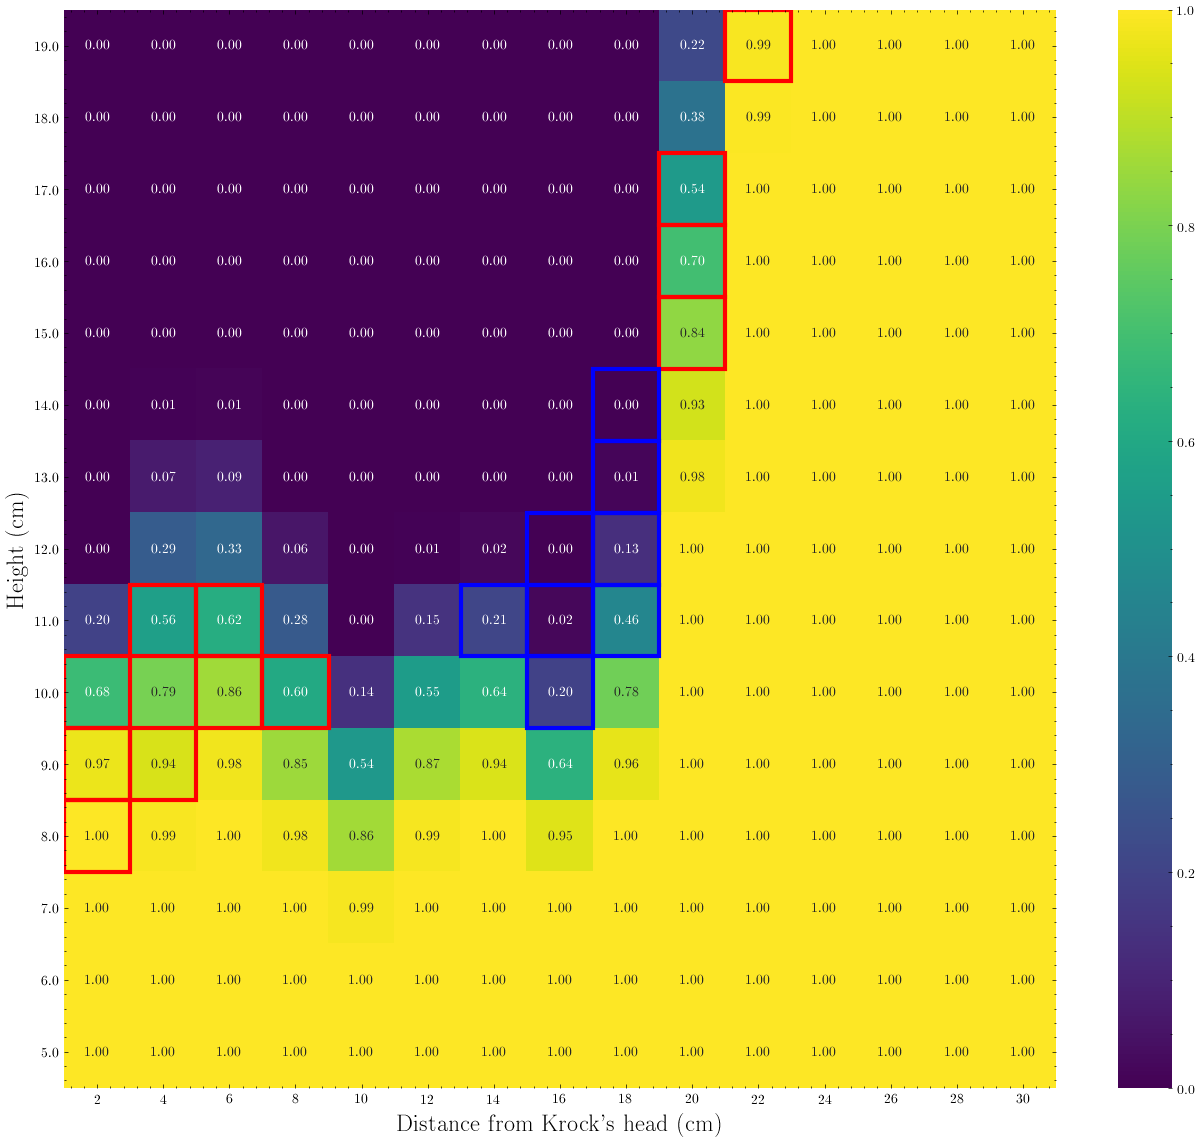

In [58]:
fig, ax = make_heatmap(explanation.df['out_1'].values)
ax = hightlight_cell(ax, false_positive_idx)
hightlight_cell(ax, false_negative_idx, color='blue')
plt.show()
fig.savefig(out_dir + '/walls_heights_preds.png', transparent=True, dpi=400)


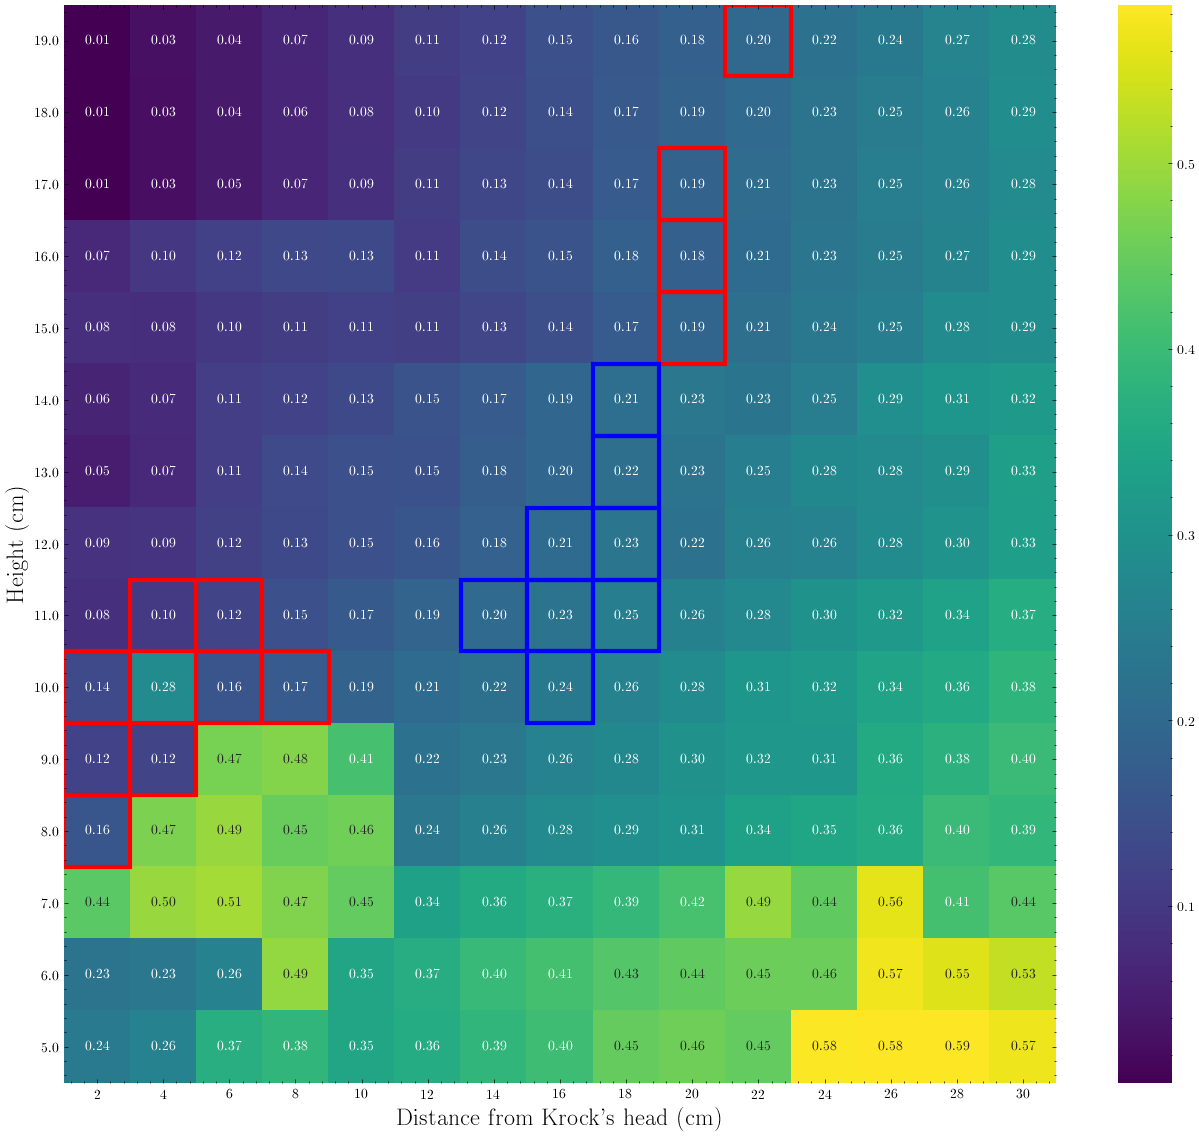

In [59]:

fig, ax = make_heatmap(advs)

ax = hightlight_cell(ax, false_positive_idx)
hightlight_cell(ax, false_negative_idx, color='blue')
plt.show()
fig.savefig(out_dir + '/walls_heights_advs.png', transparent=True,  dpi=400)

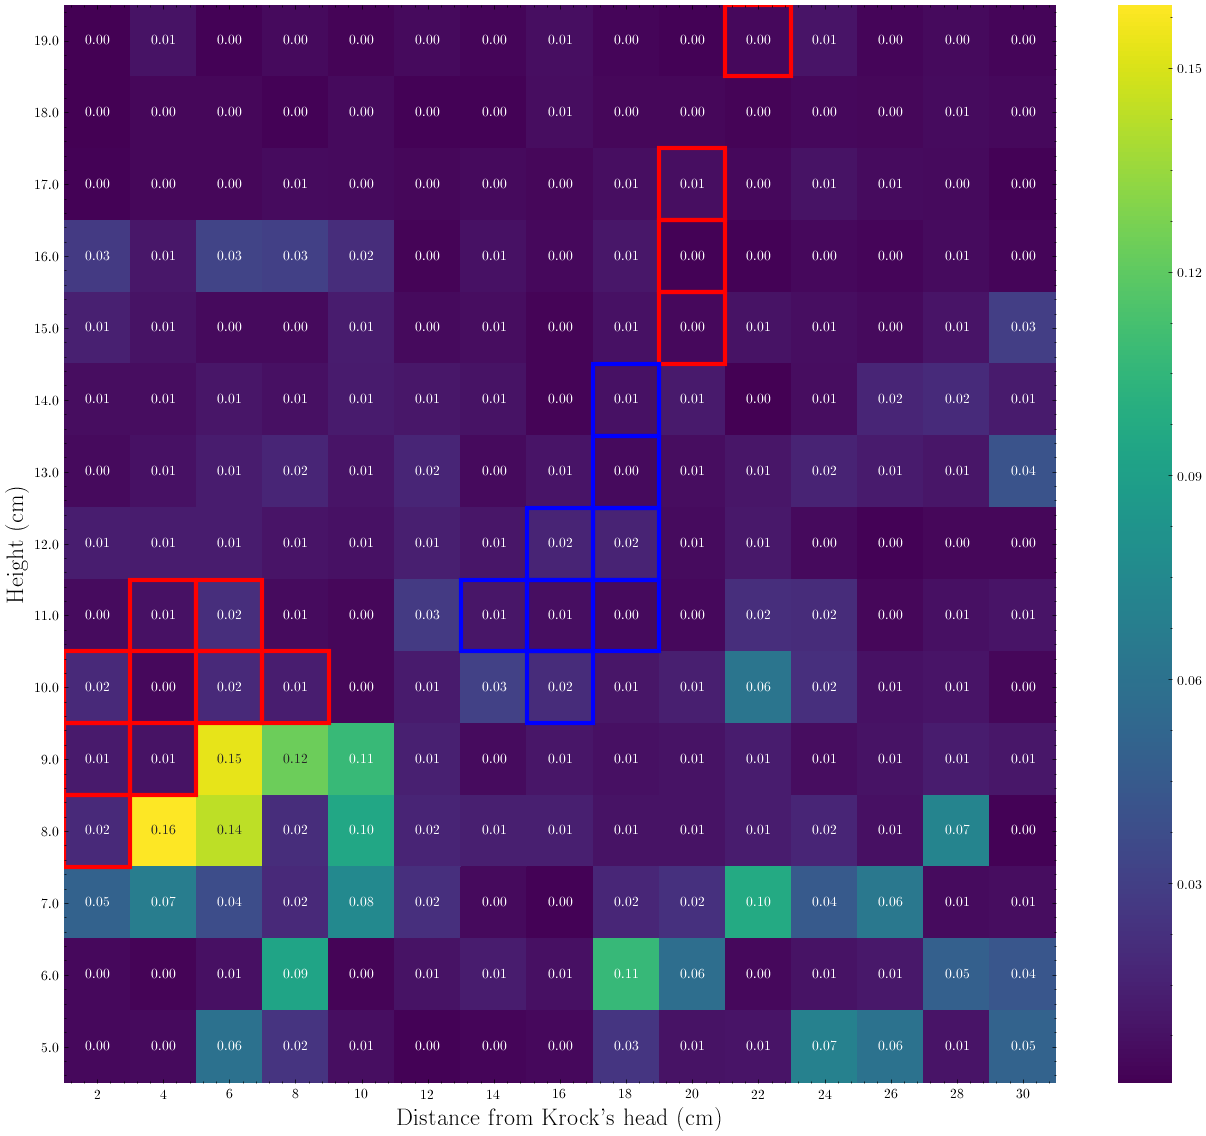

In [60]:
advs_std = np.concatenate(advs_tot, axis=0).reshape(len(advs_tot), 225)

advs_std = np.std(advs_std, axis=0)
fig, ax = make_heatmap(advs_std)

ax = hightlight_cell(ax, false_positive_idx)
hightlight_cell(ax, false_negative_idx, color='blue')
plt.show()
fig.savefig(out_dir + '/walls_heights_std.png', transparent=True,  dpi=400)

## Ramps
We can test the model against ramps with increasing hegihts

In [ ]:
answer[0].grad_cam(module, device, target_class=1).plot2d()

In [ ]:
answer[0].add_advancement_using_simulator(3, 100)
answer[0].info['advancement'].iloc[25]

In [ ]:
out_dir = '/home/francesco/Documents/Master-Thesis/papers/Thesis/img/5/custom_patches/ramp/'

heights = np.linspace(0, 2, 20) # from 1 to 20 cm (remember the res of 0.02cm/px) Krock height from ground is 4cm

walls = [RampPatch(KrockPatchExtractStrategy.patch_shape(0.7), strength=s, factors_func=lambda x: x ** 2)() 
         for s in heights ]

answer, explanation = get_answers_from_patches(walls)

explanation.df['height'] = heights ** 2
explanation.df.to_csv(out_dir + '/prediction.csv')
explanation.df

In [ ]:
plt.style.use(['science', 'ieee'])

# answer[9].add_advancement_using_simulator(seconds, time_window)
# save2d_and_2d(answer[9], out_dir, 1)
answer[10].add_advancement_using_simulator(seconds, time_window)
save2d_and_2d(answer[10], out_dir, 2)

In [ ]:
# store all the walls for the thesis
for n, p in enumerate(answer):
    p.plot3d_mayavi(0.02, size=(513,513), distance=6, save_path=out_dir + '/all/{:02d}-3d.png'.format(n), azimuth=0, color=(0,0.5,0), elevation=35, mesh=True, vmax=1)

In [ ]:
fig = plt.figure()
plt.plot(explanation.df['out_1'], label='Traversable Probability ')
plt.plot(explanation.df['out_0'], label='Not Traversable Probability')
ax = plt.gca()

ax.set_xticks(np.arange(len(heights)))
ax.set_xticklabels(['{:.1f}'.format(d) for d in heights], rotation=0)
matplotlib.rcParams['figure.figsize'] = (12,4)
ax.set_xlabel('Maximum height (m)',  fontsize=18)
ax.set_ylabel('Traversability Probability',  fontsize=18)
plt.legend()
plt.show()
fig.savefig(out_dir + '/predictions.png')

## Tunnel

In [ ]:
out_dir = '/home/francesco/Documents/Master-Thesis/papers/Thesis/img/5/custom_patches/tunnel/'

offsets = np.arange(15, 25)

tunnels = [BarPatch(KrockPatchExtractStrategy.patch_shape(0.7), strength=0.5, offset=int(o), size=size)() 
         for o in offsets ]

In [ ]:
answer, explanation = get_answers_from_patches(tunnels)

explanation.df['offset'] = offsets
explanation.df.to_csv(out_dir + 'prediction.csv')
explanation.df

In [ ]:
# store all the walls for the thesis
for n, p in enumerate(answer):
    p.plot3d_mayavi(0.02, size=(513,513), distance=3.5, save_path=out_dir + '/all/{:02d}-3d.png'.format(n), azimuth=0, color=(0,0.5,0), elevation=35, mesh=True, vmax=1)

In [ ]:
advs = []
for a in answer:
    a.add_advancement_using_simulator(seconds, time_window)
    advs.append(a.info['advancement'].iloc[25])


In [ ]:
advs

In [ ]:
plt.style.use(['science', 'ieee'])

answer[19].add_advancement_using_simulator(seconds, time_window)
save2d_and_2d(answer[19], out_dir, 1)
answer[20].add_advancement_using_simulator(seconds, time_window)
save2d_and_2d(answer[20], out_dir, 2)